In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
os.listdir('/content/drive/MyDrive/datasets/chest_xray')

['train', 'val', 'test']

In [ ]:
# === Setup
import os, random, math, time, copy
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, resnet18, ResNet50_Weights, ResNet18_Weights

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# === Paths & training config
DATASET_DIR = os.environ.get("/content/drive/MyDrive/datasets/chest_xray", "/content/drive/MyDrive/datasets/chest_xray")  # <-- set this
OUT_DIR = "./outputs_kd"
os.makedirs(OUT_DIR, exist_ok=True)

IMG_SIZE = 224
BATCH_SIZE = 64
LR = 1e-3
MOMENTUM = 0.9
TEACHER_EPOCHS = 30
STUDENT_EPOCHS = 25
DROPOUT_P = 0.6

KD_TEMPERATURE = 10.0
KD_ALPHA = 0.7  # alpha * KD + (1-alpha) * CE

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
# === Dataset loading (merge all to make a custom 70:30 split)
# The Kaggle dataset usually comes as chest_xray/train, /val, /test with 'NORMAL' and 'PNEUMONIA' subfolders.
# We'll merge them and then resplit to train/val with 70:30, to mirror the paper's pipeline.

def collect_all_images(root):
    root = Path(root)
    all_samples = []
    for split in ["train", "val", "test"]:
        p = root / split
        if not p.exists():
            continue
        for cls in ["NORMAL", "PNEUMONIA"]:
            cdir = p / cls
            if not cdir.exists():
                continue
            for imgp in cdir.rglob("*"):
                if imgp.suffix.lower() in {".png", ".jpg", ".jpeg"}:
                    all_samples.append((str(imgp), 0 if cls == "NORMAL" else 1))
    return all_samples

all_samples = collect_all_images(DATASET_DIR)
print(f"Found {len(all_samples)} images.")

# Minimal transforms (paper notes no augmentation); we will use resize+center crop+ToTensor+Normalize
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])

class XrayInlineDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

full_ds = XrayInlineDataset(all_samples, transform=base_transform)

# 70:30 split
train_size = int(0.7 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

num_classes = 2
class_names = ["NORMAL", "PNEUMONIA"]
len(train_ds), len(val_ds), class_names

Found 5856 images.


(4099, 1757, ['NORMAL', 'PNEUMONIA'])

In [ ]:
# === Models
class ClassifierHead(nn.Module):
    def __init__(self, in_features, num_classes, p=0.6):
        super().__init__()
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(in_features, num_classes)
    def forward(self, x):
        x = self.dropout(x)
        return self.fc(x)

def build_teacher(load_swav_checkpoint_path=None):
    # Placeholder: If you have SWAV weights, load backbone here.
    # Fallback: ImageNet-pretrained ResNet-50.
    if load_swav_checkpoint_path is None:
        backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    else:
        backbone = resnet50(weights=None)
        # Example for loading your SWAV weights (state dict keys may need mapping):
        state = torch.load(load_swav_checkpoint_path, map_location="cpu")
        if "state_dict" in state:
            state = state["state_dict"]
        missing, unexpected = backbone.load_state_dict(state, strict=False)
        print("Loaded SWAV weights with missing:", missing, "unexpected:", unexpected)
    in_feats = backbone.fc.in_features
    backbone.fc = ClassifierHead(in_feats, num_classes=num_classes, p=DROPOUT_P)
    return backbone

def build_student():
    student = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    in_feats = student.fc.in_features
    student.fc = ClassifierHead(in_feats, num_classes=num_classes, p=DROPOUT_P)
    return student

teacher = build_teacher(load_swav_checkpoint_path=None).to(DEVICE)
student = build_student().to(DEVICE)

sum(p.numel() for p in teacher.parameters())/1e6, sum(p.numel() for p in student.parameters())/1e6

(23.51213, 11.177538)

In [ ]:
# === Utils
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total, correct = 0, 0
    all_preds, all_labels = [], []
    running_loss = 0.0

    for xb, yb in loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
        if is_train:
            optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        if is_train:
            loss.backward()
            optimizer.step()
        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(yb.detach().cpu().numpy())

    avg_loss = running_loss / total
    acc = correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    p, r, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")
    return avg_loss, acc, p, r, f1, all_preds, all_labels

def approx_gflops_params(model, img_size=224):
    # Very rough proxy: use torchvision.ops.flop_count_table if available; otherwise, just param count.
    total_params = sum(p.numel() for p in model.parameters())
    gparams = total_params / 1e9
    return {"params": total_params, "Gparams": gparams}

approx_gflops_params(teacher), approx_gflops_params(student)

({'params': 23512130, 'Gparams': 0.02351213},
 {'params': 11177538, 'Gparams': 0.011177538})

In [ ]:
# === Train Teacher
teacher_opt = torch.optim.SGD(teacher.parameters(), lr=LR, momentum=MOMENTUM)
history_teacher = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

best_teacher = copy.deepcopy(teacher.state_dict())
best_val_acc = 0.0

for epoch in range(1, TEACHER_EPOCHS+1):
    tr_loss, tr_acc, tr_p, tr_r, tr_f1, _, _ = run_epoch(teacher, train_loader, teacher_opt)
    va_loss, va_acc, va_p, va_r, va_f1, _, _ = run_epoch(teacher, val_loader, optimizer=None)
    history_teacher["train_loss"].append(tr_loss); history_teacher["train_acc"].append(tr_acc)
    history_teacher["val_loss"].append(va_loss);   history_teacher["val_acc"].append(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_teacher = copy.deepcopy(teacher.state_dict())

    print(f"[Teacher][{epoch}/{TEACHER_EPOCHS}] "
          f"train_acc={tr_acc:.4f} val_acc={va_acc:.4f} "
          f"(P/R/F1={va_p:.4f}/{va_r:.4f}/{va_f1:.4f})")

torch.save(best_teacher, os.path.join(OUT_DIR, "teacher_best.pth"))
teacher.load_state_dict(best_teacher)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][1/30] train_acc=0.7614 val_acc=0.8947 (P/R/F1=0.8829/0.9851/0.9312)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][2/30] train_acc=0.9171 val_acc=0.9454 (P/R/F1=0.9523/0.9732/0.9626)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][3/30] train_acc=0.9432 val_acc=0.9192 (P/R/F1=0.9035/0.9945/0.9468)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][4/30] train_acc=0.9558 val_acc=0.9528 (P/R/F1=0.9605/0.9748/0.9676)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][5/30] train_acc=0.9680 val_acc=0.9437 (P/R/F1=0.9386/0.9866/0.9620)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][6/30] train_acc=0.9780 val_acc=0.9545 (P/R/F1=0.9708/0.9662/0.9685)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][7/30] train_acc=0.9741 val_acc=0.9562 (P/R/F1=0.9679/0.9717/0.9698)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][8/30] train_acc=0.9868 val_acc=0.9545 (P/R/F1=0.9501/0.9890/0.9692)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][9/30] train_acc=0.9910 val_acc=0.9636 (P/R/F1=0.9689/0.9811/0.9750)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][10/30] train_acc=0.9915 val_acc=0.9664 (P/R/F1=0.9698/0.9843/0.9770)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][11/30] train_acc=0.9949 val_acc=0.9448 (P/R/F1=0.9361/0.9913/0.9629)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][12/30] train_acc=0.9768 val_acc=0.9602 (P/R/F1=0.9688/0.9764/0.9726)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][13/30] train_acc=0.9819 val_acc=0.9647 (P/R/F1=0.9771/0.9740/0.9756)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][14/30] train_acc=0.9907 val_acc=0.9647 (P/R/F1=0.9779/0.9732/0.9756)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][15/30] train_acc=0.9954 val_acc=0.9647 (P/R/F1=0.9771/0.9740/0.9756)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][16/30] train_acc=0.9980 val_acc=0.9664 (P/R/F1=0.9757/0.9780/0.9768)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][17/30] train_acc=0.9995 val_acc=0.9641 (P/R/F1=0.9771/0.9732/0.9752)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][18/30] train_acc=0.9980 val_acc=0.9641 (P/R/F1=0.9809/0.9693/0.9751)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][19/30] train_acc=0.9851 val_acc=0.9562 (P/R/F1=0.9846/0.9544/0.9692)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][20/30] train_acc=0.9944 val_acc=0.9630 (P/R/F1=0.9801/0.9685/0.9743)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][21/30] train_acc=0.9978 val_acc=0.9676 (P/R/F1=0.9780/0.9772/0.9776)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][22/30] train_acc=0.9983 val_acc=0.9636 (P/R/F1=0.9771/0.9725/0.9748)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][23/30] train_acc=0.9939 val_acc=0.9624 (P/R/F1=0.9725/0.9756/0.9741)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][24/30] train_acc=0.9983 val_acc=0.9653 (P/R/F1=0.9697/0.9827/0.9762)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][25/30] train_acc=0.9980 val_acc=0.9664 (P/R/F1=0.9757/0.9780/0.9768)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][26/30] train_acc=0.9990 val_acc=0.9664 (P/R/F1=0.9690/0.9851/0.9770)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][27/30] train_acc=0.9998 val_acc=0.9704 (P/R/F1=0.9795/0.9795/0.9795)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][28/30] train_acc=0.9993 val_acc=0.9641 (P/R/F1=0.9646/0.9866/0.9755)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][29/30] train_acc=0.9893 val_acc=0.9710 (P/R/F1=0.9788/0.9811/0.9800)


/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-2176591312.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Teacher][30/30] train_acc=0.9988 val_acc=0.9693 (P/R/F1=0.9795/0.9780/0.9787)


<All keys matched successfully>

In [ ]:
# === Knowledge Distillation Loss
def kd_loss_fn(student_logits, teacher_logits, hard_targets, alpha=KD_ALPHA, T=KD_TEMPERATURE):
    ce = F.cross_entropy(student_logits, hard_targets)
    # KL divergence between softened probabilities
    s_log_probs = F.log_softmax(student_logits / T, dim=1)
    t_probs = F.softmax(teacher_logits / T, dim=1)
    kd = F.kl_div(s_log_probs, t_probs, reduction="batchmean") * (T * T)
    return alpha * kd + (1.0 - alpha) * ce

@torch.no_grad()
def get_teacher_logits(model, xb):
    model.eval()
    return model(xb)

def run_epoch_kd(student, teacher, loader, optimizer=None):
    is_train = optimizer is not None
    if is_train:
        student.train(True)
        teacher.eval()
    else:
        student.train(False)
        teacher.eval()

    total, correct = 0, 0
    running_loss = 0.0
    all_preds, all_labels = [], []

    for xb, yb in loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)

        with torch.no_grad():
            t_logits = teacher(xb)

        s_logits = student(xb)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            loss = kd_loss_fn(s_logits, t_logits, yb, alpha=KD_ALPHA, T=KD_TEMPERATURE)
            loss.backward()
            optimizer.step()
        else:
            loss = F.cross_entropy(s_logits, yb)

        running_loss += loss.item() * xb.size(0)
        preds = s_logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(yb.detach().cpu().numpy())

    avg_loss = running_loss / total
    acc = correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    p, r, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary")
    return avg_loss, acc, p, r, f1, all_preds, all_labels

student_opt = torch.optim.SGD(student.parameters(), lr=LR, momentum=MOMENTUM)
history_student = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

best_student = copy.deepcopy(student.state_dict())
best_val_acc_s = 0.0

for epoch in range(1, STUDENT_EPOCHS+1):
    tr_loss, tr_acc, tr_p, tr_r, tr_f1, _, _ = run_epoch_kd(student, teacher, train_loader, student_opt)
    va_loss, va_acc, va_p, va_r, va_f1, _, _ = run_epoch_kd(student, teacher, val_loader, optimizer=None)
    history_student["train_loss"].append(tr_loss); history_student["train_acc"].append(tr_acc)
    history_student["val_loss"].append(va_loss);   history_student["val_acc"].append(va_acc)

    if va_acc > best_val_acc_s:
        best_val_acc_s = va_acc
        best_student = copy.deepcopy(student.state_dict())

    print(f"[Student][{epoch}/{STUDENT_EPOCHS}] "
          f"train_acc={tr_acc:.4f} val_acc={va_acc:.4f} "
          f"(P/R/F1={va_p:.4f}/{va_r:.4f}/{va_f1:.4f})")

torch.save(best_student, os.path.join(OUT_DIR, "student_best_kd.pth"))
student.load_state_dict(best_student)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][1/25] train_acc=0.8973 val_acc=0.9698 (P/R/F1=0.9736/0.9851/0.9793)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][2/25] train_acc=0.9678 val_acc=0.9573 (P/R/F1=0.9483/0.9953/0.9712)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][3/25] train_acc=0.9783 val_acc=0.9721 (P/R/F1=0.9700/0.9921/0.9809)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][4/25] train_acc=0.9795 val_acc=0.9750 (P/R/F1=0.9912/0.9740/0.9825)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][5/25] train_acc=0.9866 val_acc=0.9750 (P/R/F1=0.9752/0.9906/0.9828)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][6/25] train_acc=0.9919 val_acc=0.9750 (P/R/F1=0.9767/0.9890/0.9828)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][7/25] train_acc=0.9937 val_acc=0.9715 (P/R/F1=0.9671/0.9945/0.9806)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][8/25] train_acc=0.9924 val_acc=0.9755 (P/R/F1=0.9865/0.9795/0.9830)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][9/25] train_acc=0.9937 val_acc=0.9761 (P/R/F1=0.9850/0.9819/0.9835)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][10/25] train_acc=0.9939 val_acc=0.9789 (P/R/F1=0.9820/0.9890/0.9855)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][11/25] train_acc=0.9944 val_acc=0.9806 (P/R/F1=0.9851/0.9882/0.9866)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][12/25] train_acc=0.9954 val_acc=0.9750 (P/R/F1=0.9804/0.9851/0.9827)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][13/25] train_acc=0.9959 val_acc=0.9721 (P/R/F1=0.9693/0.9929/0.9810)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][14/25] train_acc=0.9951 val_acc=0.9750 (P/R/F1=0.9774/0.9882/0.9828)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][15/25] train_acc=0.9949 val_acc=0.9767 (P/R/F1=0.9805/0.9874/0.9839)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][16/25] train_acc=0.9961 val_acc=0.9772 (P/R/F1=0.9790/0.9898/0.9844)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][17/25] train_acc=0.9944 val_acc=0.9761 (P/R/F1=0.9782/0.9890/0.9836)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][18/25] train_acc=0.9968 val_acc=0.9789 (P/R/F1=0.9843/0.9866/0.9855)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][19/25] train_acc=0.9976 val_acc=0.9806 (P/R/F1=0.9836/0.9898/0.9867)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][20/25] train_acc=0.9949 val_acc=0.9755 (P/R/F1=0.9873/0.9788/0.9830)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][21/25] train_acc=0.9922 val_acc=0.9767 (P/R/F1=0.9812/0.9866/0.9839)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][22/25] train_acc=0.9951 val_acc=0.9738 (P/R/F1=0.9759/0.9882/0.9820)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][23/25] train_acc=0.9966 val_acc=0.9732 (P/R/F1=0.9737/0.9898/0.9817)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][24/25] train_acc=0.9978 val_acc=0.9727 (P/R/F1=0.9715/0.9913/0.9813)


/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)
/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


[Student][25/25] train_acc=0.9968 val_acc=0.9784 (P/R/F1=0.9858/0.9843/0.9850)


<All keys matched successfully>

/tmp/ipython-input-102723975.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xb, yb = xb.to(DEVICE, non_blocking=True), torch.tensor(yb).to(DEVICE)


Final Student — Acc=0.9806, Precision=0.9851, Recall=0.9882, F1=0.9866


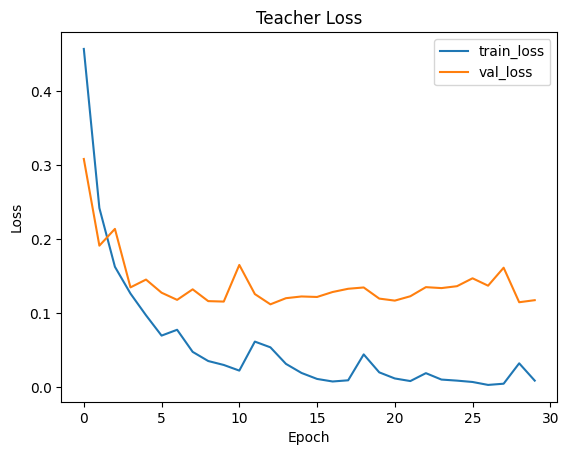

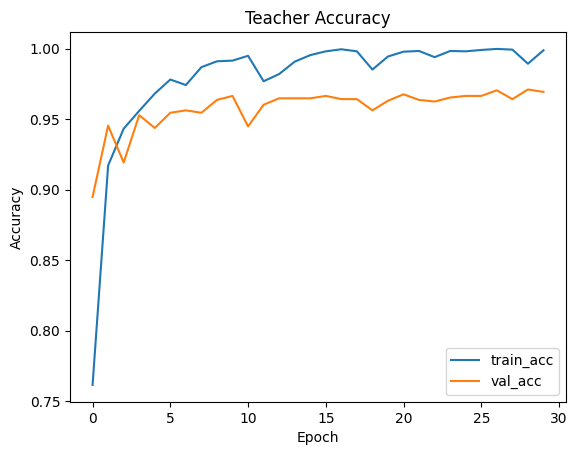

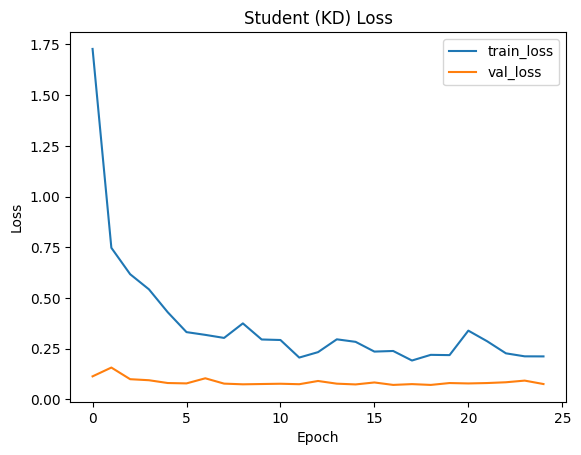

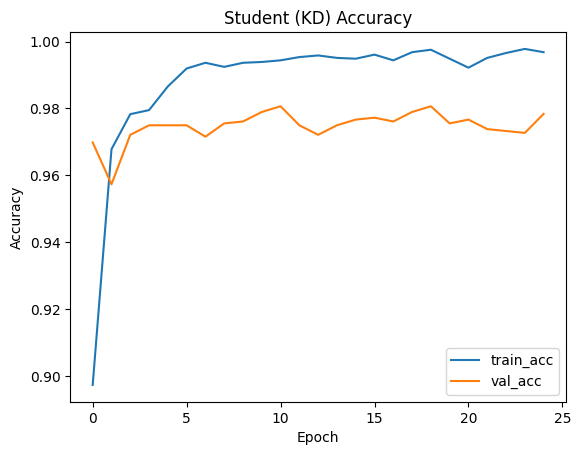

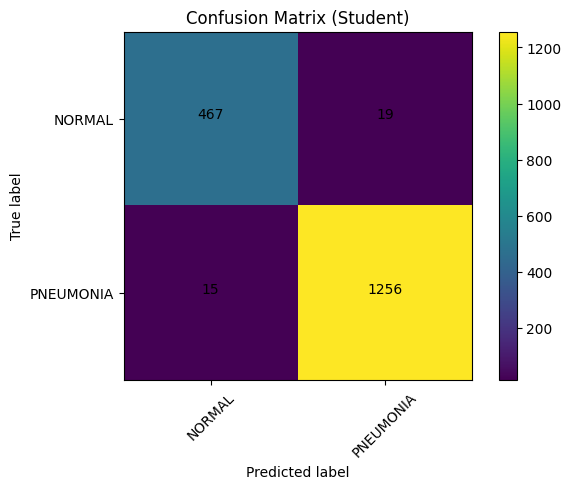

In [ ]:
# === Final Evaluation (Student)
student.eval()
_, acc, p, r, f1, preds, labels = run_epoch_kd(student, teacher, val_loader, optimizer=None)
print(f"Final Student — Acc={acc:.4f}, Precision={p:.4f}, Recall={r:.4f}, F1={f1:.4f}")

cm = confusion_matrix(labels, preds)

# Plot loss/acc curves (teacher)
plt.figure()
plt.plot(history_teacher['train_loss'], label='train_loss')
plt.plot(history_teacher['val_loss'], label='val_loss')
plt.title('Teacher Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()

plt.figure()
plt.plot(history_teacher['train_acc'], label='train_acc')
plt.plot(history_teacher['val_acc'], label='val_acc')
plt.title('Teacher Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.show()

# Plot loss/acc curves (student)
plt.figure()
plt.plot(history_student['train_loss'], label='train_loss')
plt.plot(history_student['val_loss'], label='val_loss')
plt.title('Student (KD) Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
plt.show()

plt.figure()
plt.plot(history_student['train_acc'], label='train_acc')
plt.plot(history_student['val_acc'], label='val_acc')
plt.title('Student (KD) Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
plt.show()

# Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix (Student)')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# === Save logs & basic stats
import json
logs = {
    "teacher": history_teacher,
    "student": history_student,
    "final_student_metrics": {"acc": float(acc), "precision": float(p), "recall": float(r), "f1": float(f1)},
    "teacher_params_M": sum(p.numel() for p in teacher.parameters())/1e6,
    "student_params_M": sum(p.numel() for p in student.parameters())/1e6,
}
with open(os.path.join(OUT_DIR, "training_logs.json"), "w") as f:
    json.dump(logs, f, indent=2)
print("Saved to", os.path.abspath(OUT_DIR))

Saved to /content/outputs_kd
